# Scapy in 15 minutes (or longer)

##### Guillaume Valadon & Pierre Lalet

[Scapy](http://www.secdev.org/projects/scapy) is a powerful Python-based interactive packet manipulation program and library. It can be used to forge or decode packets for a wide number of protocols, send them on the wire, capture them, match requests and replies, and much more.

This iPython notebook provides a short tour of the main Scapy features. It assumes that you are familiar with networking terminology. All examples were built using the development version from [https://github.com/secdev/scapy](https://github.com/secdev/scapy), and tested on Linux. They should work as well on OS X, and other BSD.

The current documentation is available on [http://scapy.readthedocs.io/](http://scapy.readthedocs.io/) !

Scapy eases network packets manipulation, and allows you to forge complicated packets to perform advanced tests. As a teaser, let's have a look a two examples that are difficult to express without Scapy:

1_ Sending a TCP segment with maximum segment size set to 0 to a specific port is an interesting test to perform against embedded TCP stacks. It can be achieved with the following one-liner:

In [30]:
send(IP(dst="1.2.3.4")/TCP(dport=502, options=[("MSS", 0)]))


Sent 1 packets.


2_ Advanced firewalking using IP options is sometimes useful to perform network enumeration. Here is a more complicated one-liner:

In [31]:
ans = sr([IP(dst="8.8.8.8", ttl=(1, 8), options=IPOption_RR())/ICMP(seq=RandShort()), IP(dst="8.8.8.8", ttl=(1, 8), options=IPOption_Traceroute())/ICMP(seq=RandShort()), IP(dst="8.8.8.8", ttl=(1, 8))/ICMP(seq=RandShort())], verbose=False, timeout=3)[0]
ans.make_table(lambda x, y: (", ".join(z.summary() for z in x[IP].options) or '-', x[IP].ttl, y.sprintf("%IP.src% %ICMP.type%")))

  -                            IPOption_RR                  IPOption_Traceroute          
1 192.168.42.1 time-exceeded 192.168.46.1 time-exceeded 192.168.46.1 time-exceeded 
2 172.42.0.1 time-exceeded     172.42.0.1 time-exceeded     172.42.0.1 time-exceeded     
3 42.10.69.251 time-exceeded  42.10.69.251 time-exceeded  42.10.69.251 time-exceeded  
4 10.123.156.86 time-exceeded  10.123.156.86 time-exceeded  -                            
5 69.156.98.177 time-exceeded 69.156.98.177 time-exceeded -                            
6 69.156.137.74 time-exceeded 69.156.137.74 time-exceeded -                            
7 209.85.172.150 time-exceeded -                            -                            
8 216.239.57.203 time-exceeded -                            -                            


#### Now that we've got your attention, let's start the tutorial !

## Quick setup

The easiest way to try Scapy is to clone the github repository, then launch the `run_scapy` script as root. The following examples can be pasted at the Scapy prompt. There is no need to install any external Python modules.

```shell
git clone https://github.com/secdev/scapy --depth=1
sudo ./run_scapy
Welcome to Scapy (2.4.0)
>>>
```

Note: iPython users must import scapy as follows

In [13]:
from scapy.all import *

## First steps

With Scapy, each network layer is a Python class.

The `'/'` operator is used to bind layers together. Let's put a TCP segment on top of IP and assign it to the `packet` variable, then stack it on top of Ethernet. 

In [2]:
packet = IP()/TCP()
Ether()/packet

<Ether  type=IPv4 |<IP  frag=0 proto=tcp |<TCP  |>>>

This last output displays the packet summary. Here, Scapy automatically filled the Ethernet type as well as the IP protocol field.

Protocol fields can be listed using the `ls()` function:

In [ ]:
    >>> ls(IP, verbose=True)
    version    : BitField (4 bits)                   = (4)
    ihl        : BitField (4 bits)                   = (None)
    tos        : XByteField                          = (0)
    len        : ShortField                          = (None)
    id         : ShortField                          = (1)
    flags      : FlagsField (3 bits)                 = (0)
                   MF, DF, evil
    frag       : BitField (13 bits)                  = (0)
    ttl        : ByteField                           = (64)
    proto      : ByteEnumField                       = (0)
    chksum     : XShortField                         = (None)
    src        : SourceIPField (Emph)                = (None)
    dst        : DestIPField (Emph)                  = (None)
    options    : PacketListField                     = ([])

Let's create a new packet to a specific IP destination. With Scapy, each protocol field can be specified. As shown in the `ls()` output, the interesting field is `dst`.

Scapy packets are objects with some useful methods, such as `summary()`.

In [3]:
p = Ether()/IP(dst="www.secdev.org")/TCP()
p.summary()

"Ether / IP / TCP 172.20.10.2:ftp_data > Net('www.secdev.org'):http S"

There are not many differences with the previous example. However, Scapy used the specific destination to perform some magic tricks !

Using internal mechanisms (such as DNS resolution, routing table and ARP resolution), Scapy has automatically set fields necessary to send the packet. These fields can of course be accessed and displayed.

In [10]:
print(p.dst)  # first layer that has an src field, here Ether
print(p[IP].src)  # explicitly access the src field of the IP layer

# sprintf() is a useful method to display fields
print(p.sprintf("%Ether.src% > %Ether.dst%\n%IP.src% > %IP.dst%"))

3a:71:de:90:0b:64
172.20.10.2
b8:e8:56:45:8c:e6 > 3a:71:de:90:0b:64
172.20.10.2 > Net('www.secdev.org')


Scapy uses default values that work most of the time. For example, `TCP()` is a SYN segment to port 80.

In [9]:
print(p.sprintf("%TCP.flags% %TCP.dport%"))

S http


Moreover, Scapy has implicit packets. For example, they are useful to make the TTL field value vary from 1 to 5 to mimic traceroute.

In [11]:
[p for p in IP(ttl=(1,5))/ICMP()]

[<IP  frag=0 ttl=1 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=2 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=3 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=4 proto=icmp |<ICMP  |>>,
 <IP  frag=0 ttl=5 proto=icmp |<ICMP  |>>]

## Sending and receiving

Currently, you know how to build packets with Scapy. The next step is to send them over the network !

The `sr1()` function sends a packet and returns the corresponding answer. `srp1()` does the same for layer two packets, i.e. Ethernet. If you are only interested in sending packets `send()` is your friend.

As an example, we can use the DNS protocol to get www.example.com IPv4 address.

In [23]:
p = sr1(IP(dst="8.8.8.8")/UDP()/DNS(qd=DNSQR()))
p[DNS].an


Received 19 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished to send 1 packets.


<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=10011 rdata='93.184.216.34' |>

Another alternative is the `sr()` function. Like `srp1()`, the `sr1()` function can be used for layer 2 packets.

In [47]:
r, u = srp(Ether()/IP(dst="8.8.8.8", ttl=(5,10))/UDP()/DNS(rd=1, qd=DNSQR(qname="www.example.com")))
r, u


Received 7 packets, got 6 answers, remaining 0 packets
Begin emission:
Finished to send 6 packets.


(<Results: TCP:0 UDP:0 ICMP:6 Other:0>,
 <Unanswered: TCP:0 UDP:0 ICMP:0 Other:0>)

`sr()` sent a list of packets, and returns two variables, here `r` and `u`, where:
1. `r` is a list of results (i.e tuples of the packet sent and its answer)
2. `u` is a list of unanswered packets

In [48]:
# Access the first tuple
print(r[0][0].summary())  # the packet sent
print(r[0][1].summary())  # the answer received

# Access the ICMP layer. Scapy received a time-exceeded error message
r[0][1][ICMP]

Ether / IP / UDP / DNS Qry "www.example.com" 
Ether / IP / ICMP / IPerror / UDPerror / DNS Qry "www.example.com." 


<ICMP  type=time-exceeded code=ttl-zero-during-transit chksum=0x50d6 reserved=0 length=0 unused=None |<IPerror  version=4L ihl=5L tos=0x0 len=61 id=1 flags= frag=0L ttl=1 proto=udp chksum=0xf389 src=172.20.10.2 dst=8.8.8.8 options=[] |<UDPerror  sport=domain dport=domain len=41 chksum=0x593a |<DNS  id=0 qr=0L opcode=QUERY aa=0L tc=0L rd=1L ra=0L z=0L ad=0L cd=0L rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=None ns=None ar=None |>>>>

With Scapy, list of packets, such as `r` or `u`, can be easily written to, or read from PCAP files.

In [50]:
wrpcap("scapy.pcap", r)

pcap_p = rdpcap("scapy.pcap")
pcap_p[0]

<Ether  dst=f4:ce:46:a9:e0:4b src=34:95:db:04:3c:29 type=IPv4 |<IP version=4L ihl=5L tos=0x0 len=61 id=1 flags= frag=0L ttl=5 proto=udp chksum=0xb6e3 src=192.168.46.20 dst=8.8.8.8 options=[] |<UDP sport=domain dport=domain len=41 chksum=0xb609 |<DNS  id=0 qr=0L opcode=QUERY aa=0L tc=0L rd=1L ra=0L z=0L ad=0L cd=0L rcode=ok qdcount=1 ancount=0 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=None ns=None ar=None |>>>>

Sniffing the network is as straightforward as sending and receiving packets. The `sniff()` function returns a list of Scapy packets, that can be manipulated as previously described.

In [52]:
s = sniff(count=2)
s

<Sniffed: TCP:0 UDP:2 ICMP:0 Other:0>

`sniff()` has many arguments. The `prn` one accepts a function name that will be called on received packets. Using the `lambda` keyword, Scapy could be used to mimic the `tshark` command behavior.

In [53]:
sniff(count=2, prn=lambda p: p.summary())

Ether / IP / TCP 172.20.10.2:52664 > 216.58.208.200:https A
Ether / IP / TCP 216.58.208.200:https > 172.20.10.2:52664 A


<Sniffed: TCP:2 UDP:0 ICMP:0 Other:0>

Alternatively, Scapy can use OS sockets to send and receive packets. The following example assigns an UDP socket to a Scapy `StreamSocket`, which is then used to query www.example.com IPv4 address.
Unlike other Scapy sockets, `StreamSockets` do not require root privileges.

In [79]:
import socket

sck = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)  # create an UDP socket
sck.connect(("8.8.8.8", 53))  # connect to 8.8.8.8 on 53/UDP

# Create the StreamSocket and gives the class used to decode the answer
ssck = StreamSocket(sck)
ssck.basecls = DNS

# Send the DNS query
ssck.sr1(DNS(rd=1, qd=DNSQR(qname="www.example.com")))


Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished to send 1 packets.


<DNS  id=0 qr=1L opcode=QUERY aa=0L tc=0L rd=1L ra=1L z=0L ad=0L cd=0L rcode=ok qdcount=1 ancount=1 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=19681 rdata='93.184.216.34' |> ns=None ar=None |>

## Visualization
Parts of the following examples require the [matplotlib](http://matplotlib.org/) module.

With `srloop()`, we can send 100 ICMP packets to 8.8.8.8 and 8.8.4.4.

In [25]:
ans, unans = srloop(IP(dst=["8.8.8.8", "8.8.4.4"])/ICMP(), inter=.1, timeout=.1, count=100, verbose=False)

Then we can use the results to plot the IP id values.

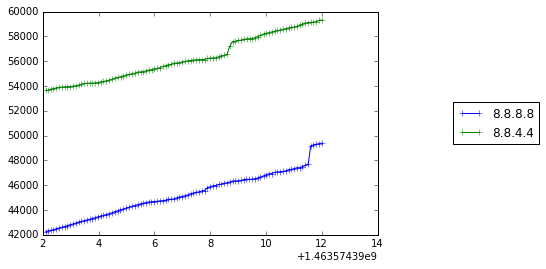

[[<matplotlib.lines.Line2D at 0x7f2c2e113d10>],

In [26]:
%matplotlib inline
ans.multiplot(lambda x, y: (y[IP].src, (y.time, y[IP].id)), plot_xy=True)

The `raw()` constructor can be used to "build" the packet's bytes as they would be sent on the wire.

In [8]:
pkt = IP() / UDP() / DNS(qd=DNSQR())
print(repr(raw(pkt)))

b'E\x00\x00=\x00\x01\x00\x00@\x11|\xad\x7f\x00\x00\x01\x7f\x00\x00\x01\x005\x005\x00)\xb6\xd3\x00\x00\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x03www\x07example\x03com\x00\x00\x01\x00\x01'


Since some people cannot read this representation, Scapy can:
  - give a summary for a packet

In [10]:
print(pkt.summary())

IP / UDP / DNS Qry "www.example.com" 


  - "hexdump" the packet's bytes

In [18]:
hexdump(pkt)

0000   45 00 00 3D 00 01 00 00  40 11 7C AD 7F 00 00 01   E..=....@.|.....
0010   7F 00 00 01 00 35 00 35  00 29 B6 D3 00 00 01 00   .....5.5.)......
0020   00 01 00 00 00 00 00 00  03 77 77 77 07 65 78 61   .........www.exa
0030   6D 70 6C 65 03 63 6F 6D  00 00 01 00 01            mple.com.....


  - dump the packet, layer by layer, with the values for each field

In [11]:
pkt.show()

###[ IP ]###
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = udp
  chksum    = None
  src       = 127.0.0.1
  dst       = 127.0.0.1
  \options   \
###[ UDP ]###
     sport     = domain
     dport     = domain
     len       = None
     chksum    = None
###[ DNS ]###
        id        = 0
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 1
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 0
        \qd        \
         |###[ DNS Question Record ]###
         |  qname     = 'www.example.com'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
        ar        = None


  - render a pretty and handy dissection of the packet

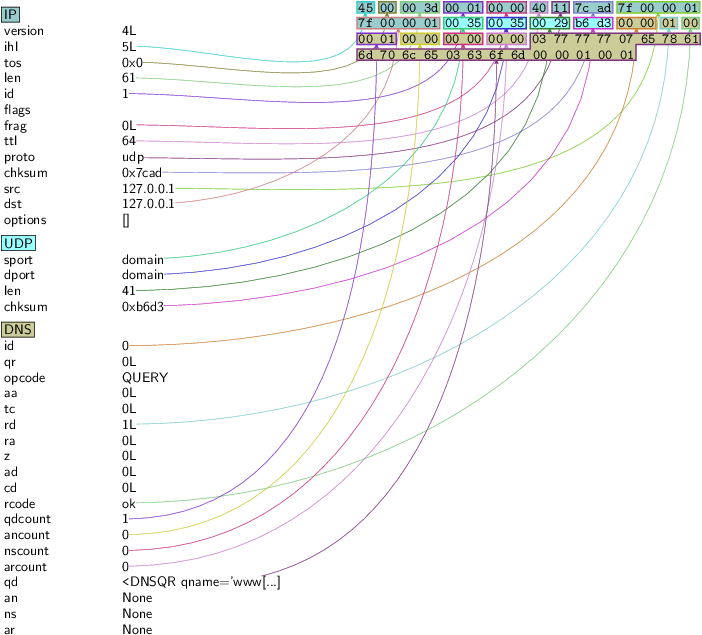

In [15]:
pkt.canvas_dump()

Scapy has a `traceroute()` function, which basically runs a `sr(IP(ttl=(1..30))` and creates a `TracerouteResult` object, which is a specific subclass of `SndRcvList()`.

In [22]:
ans, unans = traceroute('www.secdev.org', maxttl=15)

Begin emission:
Finished to send 15 packets.

Received 17 packets, got 15 answers, remaining 0 packets
   217.25.178.5:tcp80 
1  192.168.46.254  11 
2  172.28.0.1      11 
3  80.10.115.251   11 
4  10.123.205.82   11 
5  193.252.98.161  11 
6  193.252.137.74  11 
7  193.251.132.183 11 
8  130.117.49.41   11 
9  154.25.7.150    11 
10 154.25.7.150    11 
11 149.6.166.166   11 
12 149.6.166.166   11 
13 217.25.178.5    SA 
14 217.25.178.5    SA 
15 217.25.178.5    SA 


The result can be plotted with `.world_trace()` (this requires GeoIP module and data, from [MaxMind](https://www.maxmind.com/))

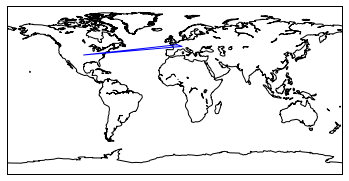

[[<matplotlib.lines.Line2D at 0x7f2c23b62850>]]

In [23]:
ans.world_trace()

The `PacketList.make_table()` function can be very helpful. Here is a simple "port scanner":

In [29]:
ans = sr(IP(dst=["scanme.nmap.org", "nmap.org"])/TCP(dport=[22, 80, 443, 31337]), timeout=3, verbose=False)[0]
ans.extend(sr(IP(dst=["scanme.nmap.org", "nmap.org"])/UDP(dport=53)/DNS(qd=DNSQR()), timeout=3, verbose=False)[0])
ans.make_table(lambda x, y: (x[IP].dst, x.sprintf('%IP.proto%/{TCP:%r,TCP.dport%}{UDP:%r,UDP.dport%}'), y.sprintf('{TCP:%TCP.flags%}{ICMP:%ICMP.type%}')))

          45.33.32.156 45.33.49.119 
tcp/22    SA           SA           
tcp/31337 SA           RA           
tcp/443   RA           SA           
tcp/80    SA           SA           
udp/53    dest-unreach -            


## Implementing a new protocol

Scapy can be easily extended to support new protocols.

The following example defines DNS over TCP. The `DNSTCP` class inherits from `Packet` and defines two field: the length, and the real DNS message. The `length_of` and `length_from` arguments link the `len` and `dns` fields together. Scapy will be able to automatically compute the `len` value.

In [119]:
class DNSTCP(Packet):
    name = "DNS over TCP"
    
    fields_desc = [ FieldLenField("len", None, fmt="!H", length_of="dns"),
                    PacketLenField("dns", 0, DNS, length_from=lambda p: p.len)]
    
    # This method tells Scapy that the next packet must be decoded with DNSTCP
    def guess_payload_class(self, payload):
        return DNSTCP

This new packet definition can be direcly used to build a DNS message over TCP.

In [120]:
# Build then decode a DNS message over TCP
DNSTCP(raw(DNSTCP(dns=DNS())))

<DNSTCP  len=12 dns=<DNS  id=0 qr=0L opcode=QUERY aa=0L tc=0L rd=0L ra=0L z=0L ad=0L cd=0L rcode=ok qdcount=0 ancount=0 nscount=0 arcount=0 |> |>

Modifying the previous `StreamSocket` example to use TCP allows to use the new `DNSCTP` layer easily.

In [122]:
import socket

sck = socket.socket(socket.AF_INET, socket.SOCK_STREAM)  # create an TCP socket
sck.connect(("8.8.8.8", 53))  # connect to 8.8.8.8 on 53/TCP

# Create the StreamSocket and gives the class used to decode the answer
ssck = StreamSocket(sck)
ssck.basecls = DNSTCP

# Send the DNS query
ssck.sr1(DNSTCP(dns=DNS(rd=1, qd=DNSQR(qname="www.example.com"))))


Received 1 packets, got 1 answers, remaining 0 packets
Begin emission:
Finished to send 1 packets.


<DNSTCP  len=49 dns=<DNS  id=0 qr=1L opcode=QUERY aa=0L tc=0L rd=1L ra=1L z=0L ad=0L cd=0L rcode=ok qdcount=1 ancount=1 nscount=0 arcount=0 qd=<DNSQR  qname='www.example.com.' qtype=A qclass=IN |> an=<DNSRR  rrname='www.example.com.' type=A rclass=IN ttl=12101 rdata='93.184.216.34' |> ns=None ar=None |> |>

## Scapy as a module

So far, Scapy was only used from the command line. It is also a Python module than can be used to build specific network tools, such as ping6.py:

In [ ]:
    from scapy.all import *
    import argparse

    parser = argparse.ArgumentParser(description="A simple ping6")
    parser.add_argument("ipv6_address", help="An IPv6 address")
    args = parser.parse_args()

    print(sr1(IPv6(dst=args.ipv6_address)/ICMPv6EchoRequest(), verbose=0).summary())

## Answering machines

A lot of attack scenarios look the same: you want to wait for a specific packet, then send an answer to trigger the attack.

To this extent, Scapy provides the `AnsweringMachine` object. Two methods are especially useful:
1. `is_request()`: return True if the `pkt` is the expected request
2. `make_reply()`: return the packet that must be sent

The following example uses Scapy Wi-Fi capabilities to pretend that a "Scapy !" access point exists.

Note: your Wi-Fi interface must be set to monitor mode !

In [129]:
# Specify the Wi-Fi monitor interface
#conf.iface = "mon0"  # uncomment to test

# Create an answering machine
class ProbeRequest_am(AnsweringMachine):
  function_name = "pram"

  # The fake mac of the fake access point
  mac = "00:11:22:33:44:55"

  def is_request(self, pkt):
    return Dot11ProbeReq in pkt

  def make_reply(self, req):

    rep = RadioTap()
    # Note: depending on your Wi-Fi card, you might need a different header than RadioTap()
    rep /= Dot11(addr1=req.addr2, addr2=self.mac, addr3=self.mac, ID=RandShort(), SC=RandShort())
    rep /= Dot11ProbeResp(cap="ESS", timestamp=time.time())
    rep /= Dot11Elt(ID="SSID",info="Scapy !")
    rep /= Dot11Elt(ID="Rates",info=b'\x82\x84\x0b\x16\x96')
    rep /= Dot11Elt(ID="DSset",info=chr(10))

    OK,return rep

# Start the answering machine
#ProbeRequest_am()()  # uncomment to test

## Cheap Man-in-the-middle with NFQUEUE

NFQUEUE is an iptables target than can be used to transfer packets to userland process. As a nfqueue module is available in Python, you can take advantage of this Linux feature to perform Scapy based MiTM.

This example intercepts ICMP Echo request messages sent to 8.8.8.8, sent with the ping command, and modify their sequence numbers. In order to pass packets to Scapy, the following `iptable` command put packets into the NFQUEUE #2807:

$ sudo iptables -I OUTPUT --destination 8.8.8.8 -p icmp -o eth0 -j NFQUEUE --queue-num 2807

In [ ]:
    from scapy.all import *
    import nfqueue, socket

    def scapy_cb(i, payload):
      s = payload.get_data()  # get and parse the packet
      p = IP(s)

      # Check if the packet is an ICMP Echo Request to 8.8.8.8
      if p.dst == "8.8.8.8" and ICMP in p:
        # Delete checksums to force Scapy to compute them
        del(p[IP].chksum, p[ICMP].chksum)
        
        # Set the ICMP sequence number to 0
        p[ICMP].seq = 0
        
        # Let the modified packet go through
        ret = payload.set_verdict_modified(nfqueue.NF_ACCEPT, raw(p), len(p))
        
      else:
        # Accept all packets
        payload.set_verdict(nfqueue.NF_ACCEPT)

    # Get an NFQUEUE handler
    q = nfqueue.queue()
    # Set the function that will be call on each received packet
    q.set_callback(scapy_cb)
    # Open the queue & start parsing packes
    q.fast_open(2807, socket.AF_INET)
    q.try_run()

# Automaton

When more logic is needed, Scapy provides a clever way abstraction to define an automaton. In a nutshell, you need to define an object that inherits from `Automaton`, and implement specific methods:
- states: using the `@ATMT.state` decorator. They usually do nothing
- conditions: using the `@ATMT.condition` and `@ATMT.receive_condition` decorators. They describe how to go from one state to another
- actions: using the `ATMT.action` decorator. They describe what to do, like sending a back, when changing state

The following example does nothing more than trying to mimic a TCP scanner:

In [6]:
class TCPScanner(Automaton):

    @ATMT.state(initial=1)
    def BEGIN(self):
        pass

    @ATMT.state()
    def SYN(self):
        print("-> SYN")

    @ATMT.state()
    def SYN_ACK(self):
        print("<- SYN/ACK")
        raise self.END()

    @ATMT.state()
    def RST(self):
        print("<- RST")
        raise self.END()

    @ATMT.state()
    def ERROR(self):
        print("!! ERROR")
        raise self.END()
    @ATMT.state(final=1)
    def END(self):
        pass
    
    @ATMT.condition(BEGIN)
    def condition_BEGIN(self):
        raise self.SYN()

    @ATMT.condition(SYN)
    def condition_SYN(self):

        if random.randint(0, 1):
            raise self.SYN_ACK()
        else:
            raise self.RST()

    @ATMT.timeout(SYN, 1)
    def timeout_SYN(self):
        raise self.ERROR()

TCPScanner().run()

-> SYN
<- SYN/ACK


In [7]:
TCPScanner().run()

-> SYN
<- RST


# Pipes

Pipes are an advanced Scapy feature that aims sniffing, modifying and printing packets. The API provides several buildings blocks. All of them, have high entries and exits (>>) as well as low (>) ones.

For example, the `CliFeeder` is used to send message from the Python command line to a low exit. It can be combined to the `InjectSink` that reads message on its low entry and inject them to the specified network interface. These blocks can be combined as follows:

In [ ]:
# Instantiate the blocks
clf = CLIFeeder()
ijs = InjectSink("enx3495db043a28")

# Plug blocks together
clf > ijs

# Create and start the engine
pe = PipeEngine(clf)
pe.start()

Packet can be sent using the following command on the prompt:

In [ ]:
clf.send("Hello Scapy !")